# Sentiment Analysis

Team member:    m5271014 Hibiki Koishikawa, m5271015 Kota Kokubun

We investigated sentiment analysis(positive or negative) as document classification in the field of Natural Langueage Processing(NLP). NLP is one of the most interesting topic with the emergence of Large Language Model(LLM) like ChatGPT. Also, document classification is known as important task in NLP that can be applied to the analysis such as product reviews. 

Approach
* Preprocess WRIME dataset
* Fine-tune a pre-trained model(Validate per epoch and choose best model that validation loss is the lowest)
* Save the result with changing hyperparameters
* Visualize the result

In [2]:
# import library

# import glob
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification

# define constant
MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"

# settings for random value
seed = 0
random.seed(seed)

# settings for hyperparameters
batch_size = 32
epoch = 5
lr = 1e-5


# ! pip install fugashi ipadic

/home/hibiki/anaconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# download WRIME dataset
# ! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver2.tsva

In [37]:
wrime_df = pd.read_table("wrime-ver2.tsv")
# wrime_df.info()
# wrime_df["Avg. Readers_Sentiment"].value_counts()
wrime_df.head()

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Sentiment,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust,Avg. Readers_Sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,2012/7/31 23:48,train,0,1,2,1,1,0,...,-1,0,2,0,0,0,0,0,0,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,2012/8/2 23:09,train,3,0,3,0,0,0,...,1,1,0,0,2,0,0,0,0,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,1,2012/8/5 0:50,train,1,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,眠い、眠れない。,1,2012/8/8 1:36,train,0,2,1,0,0,1,...,-1,0,1,0,0,0,0,1,0,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/8/9 22:24,train,2,1,3,2,0,1,...,0,1,0,0,1,0,0,0,0,0


In [38]:
wrime_df = wrime_df[wrime_df["Avg. Readers_Sentiment"] != 0]

In [39]:
wrime_df["Avg. Readers_Sentiment"].value_counts()

-1    10468
 1     9138
 2     2245
-2     1687
Name: Avg. Readers_Sentiment, dtype: int64

In [40]:
# prepare tokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

# format each data
max_length = 128
dataset_for_loader = []

for sentence, label in zip(wrime_df["Sentence"], wrime_df["Avg. Readers_Sentiment"]):
    encoding = tokenizer(
        sentence,
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    # remove neutral emotional polarity and divide into positive and negative
    if label > 0:
        encoding["labels"] = 1
    elif label < 0:
        encoding["labels"] = 0

    encoding = {k: torch.tensor(v) for k, v in encoding.items()}
    dataset_for_loader.append(encoding)

# sample
dataset_for_loader[0]

{'input_ids': tensor([    2,  3937, 28517, 26099,    15,    16,  3318, 12272,   640,     8,
          1131, 28479,    31,    40,  2949,     7,    12,  1549,  5602,  3215,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [41]:
dataset_for_loader[19]["labels"]

tensor(0)

In [42]:
# divide dataset into train, valid, test data
# shuffle data
random.shuffle(dataset_for_loader)

n = len(dataset_for_loader)
n_train = int(0.6*n)
n_val = int(0.2*n)

dataset_train = dataset_for_loader[:n_train] # training data
dataset_val = dataset_for_loader[n_train:n_train+n_val] # validation data
dataset_test = dataset_for_loader[n_train+n_val:] # test data

dataloader_train = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True # change batch_size 16, 32, 64, 128 or 256
)
dataloader_val = DataLoader(dataset_val, batch_size=256)
dataloader_test = DataLoader(dataset_test, batch_size=256)

In [43]:
class BertForSequenceClassification_pl(pl.LightningModule):    

    def __init__(self, model_name, num_labels, lr):

        super().__init__()
        self.save_hyperparameters() 

        # loading BERT
        self.bert_sc = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

    def training_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        
        return loss
    

    def validation_step(self, batch, batch_idx):
        """
        validate the model per epoch"""
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss) 


    def test_step(self, batch, batch_idx):
        labels = batch.pop('labels') 
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        num_correct = ( labels_predicted == labels ).sum().item()
        accuracy = num_correct/labels.size(0)
        self.log('accuracy', accuracy)

        TP, TN, FP, FN = 0, 0, 0, 0
        
        for predicted, label in zip(labels_predicted, labels):
            if predicted == label:
                if predicted == 1:
                    TP += 1
                else:
                    TN += 1
            elif predicted == 0:
                FN += 1
            elif predicted == 1:
                FP += 1
        
        print(f"table :{TP}, {TN}, {FP}, {FN}")

        recall = TP / (TP + FN + 1e-5)
        precision = TP / (TP + FP + 1e-5)
        f1_score = (2*recall*precision) / (recall + precision + 1e-5)
        
        self.log("recall", recall)
        self.log("precision", precision)
        self.log("f1-score", f1_score)



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [44]:
# settings for checkpoint
# save the model that validation loss is lowest
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/',
)

trainer = pl.Trainer(
    max_epochs=epoch, # change epoch 1, 5, 10, 15 or 20
    callbacks = [checkpoint]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
# load model using pl
model = BertForSequenceClassification_pl(
    MODEL_NAME, num_labels=2, lr=lr # change learning rate 
)

# fine-tune
trainer.fit(model, dataloader_train, dataloader_val)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 112.79it/s]

/home/hibiki/anaconda3/envs/ds/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/hibiki/anaconda3/envs/ds/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 442/442 [01:11<00:00,  6.17it/s, v_num=49]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 442/442 [01:11<00:00,  6.17it/s, v_num=49]


In [46]:
# test
test = trainer.test(dataloaders=dataloader_test)
print(f'Accuracy: {test[0]["accuracy"]:.2f}')

/home/hibiki/anaconda3/envs/ds/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/hibiki/PDL-project/model/epoch=0-step=442-v38.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/hibiki/PDL-p

Testing DataLoader 0: 100%|██████████| 19/19 [00:06<00:00,  2.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.8914843797683716
        f1-score            0.8901351690292358
        precision           0.8636934161186218
         recall             0.9189045429229736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Accuracy: 0.89


In [47]:
test

[{'accuracy': 0.8914843797683716,
  'recall': 0.9189045429229736,
  'precision': 0.8636934161186218,
  'f1-score': 0.8901351690292358}]

In [ ]:
%reload tensorboard
%tensorboard --logdir ./

In [48]:
# run this program changing hyperparameters(batch size, epoch, lr) and save the result to csv file
try:
    df1 = pd.read_csv("result_epoch.csv", index_col=0)
    # df1 = pd.read_csv("result_lr.csv", index_col=0)
    # df1 = pd.read_csv("result_batch_size.csv", index_col=0)
except:
    df1 = pd.DataFrame()
df1

,accuracy,recall,precision,f1-score
"batch_size=32, epoch=20, lr=1e-05",0.900191,0.914490,0.881431,0.897368
"batch_size=32, epoch=15, lr=1e-05",0.890423,0.869597,0.899240,0.883748
"batch_size=32, epoch=10, lr=1e-05",0.902102,0.898252,0.897678,0.897648
"batch_size=32, epoch=5, lr=1e-05",0.896156,0.901942,0.883583,0.892350
"batch_size=32, epoch=1, lr=1e-05",0.892121,0.895128,0.881604,0.888120


In [49]:
df = pd.DataFrame(test, index=[batch_size])
# df = pd.DataFrame(test, index=[epoch])
# df = pd.DataFrame(test, index=[lr])
df

,accuracy,recall,precision,f1-score
"batch_size=32, epoch=25, lr=1e-05",0.891484,0.918905,0.863693,0.890135


In [50]:
df = pd.concat([df, df1])
df

,accuracy,recall,precision,f1-score
"batch_size=32, epoch=25, lr=1e-05",0.891484,0.918905,0.863693,0.890135
"batch_size=32, epoch=20, lr=1e-05",0.900191,0.914490,0.881431,0.897368
"batch_size=32, epoch=15, lr=1e-05",0.890423,0.869597,0.899240,0.883748
"batch_size=32, epoch=10, lr=1e-05",0.902102,0.898252,0.897678,0.897648
"batch_size=32, epoch=5, lr=1e-05",0.896156,0.901942,0.883583,0.892350
"batch_size=32, epoch=1, lr=1e-05",0.892121,0.895128,0.881604,0.888120


In [51]:
df.to_csv("result_epoch.csv", sep=",", index=True)
# df.to_csv("result_batch_size.csv", sep=",", index=True)
# df.to_csv("result_lr.csv", sep=",", index=True)

In [3]:
df_batch = pd.read_csv("result_batch_size.csv", sep=",", index_col=0)
df_batch

,accuracy,recall,precision,f1-score
256,NaN,NaN,NaN,NaN
128,0.872372,0.921608,0.830454,0.873383
64,0.884477,0.856459,0.897771,0.876380
32,0.888724,0.878913,0.887850,0.883011
16,0.893820,0.879917,0.896747,0.887975
8,0.884901,0.841724,0.911109,0.874707
4,0.896793,0.879674,0.902584,0.890639
2,0.892546,0.888933,0.887222,0.887760


In [4]:
df_epoch = pd.read_csv("result_epoch.csv", sep=",", index_col=0)
df_epoch

,accuracy,recall,precision,f1-score
25,0.891484,0.918905,0.863693,0.890135
20,0.900191,0.914490,0.881431,0.897368
15,0.890423,0.869597,0.899240,0.883748
10,0.902102,0.898252,0.897678,0.897648
5,0.896156,0.901942,0.883583,0.892350
1,0.892121,0.895128,0.881604,0.888120


In [13]:
df_lr = pd.read_csv("result_lr.csv", sep=",", index_col=0)
df_lr

,accuracy,recall,precision,f1-score
1.000000e-09,0.517520,0.004858,0.258228,0.009502
1.000000e-08,0.538968,0.063767,0.741831,0.116902
1.000000e-07,0.579316,0.707287,0.547839,0.616524
1.000000e-06,0.836271,0.797194,0.852096,0.823426
1.000000e-05,0.887662,0.918563,0.857573,0.886737
1.100000e-05,0.894245,0.904895,0.878835,0.891300
1.200000e-05,0.890423,0.901050,0.874567,0.887350
1.500000e-05,0.890847,0.884751,0.887739,0.885849
2.000000e-05,0.890423,0.924144,0.858669,0.889854
5.000000e-05,0.889998,0.906794,0.869571,0.887444


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


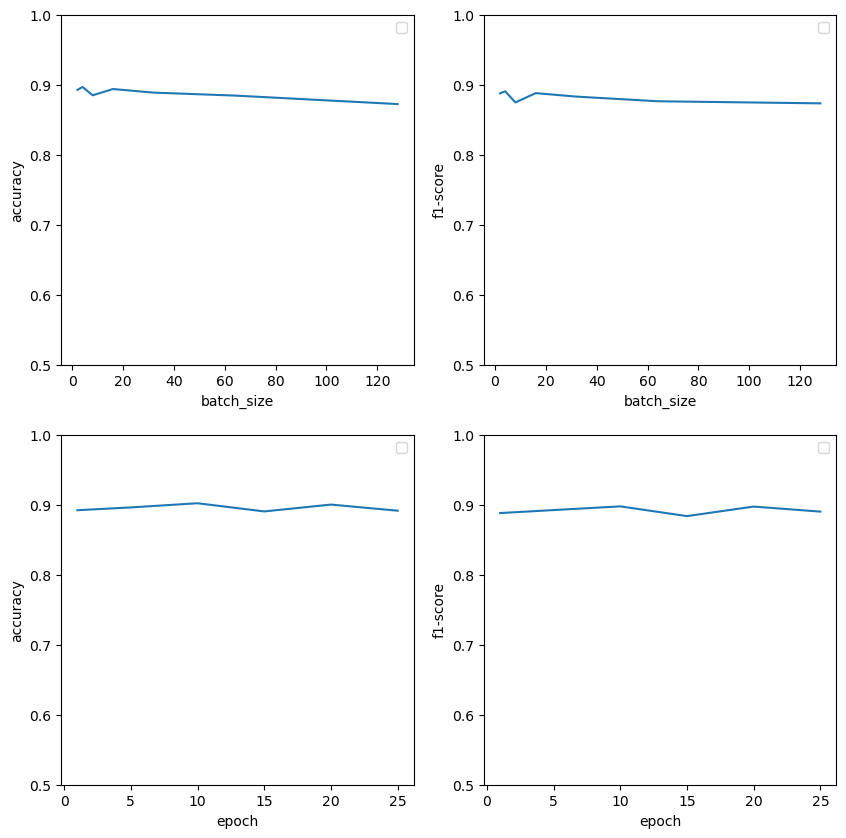

In [9]:
# visualize the result

fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(221, ylim=(0.5, 1))
ax2 = fig.add_subplot(222, ylim=(0.5, 1))
ax3 = fig.add_subplot(223, ylim=(0.5, 1))
ax4 = fig.add_subplot(224, ylim=(0.5, 1))

ax1.plot(df_batch.index, df_batch["accuracy"])
ax2.plot(df_batch.index, df_batch["f1-score"])
ax3.plot(df_epoch.index, df_epoch["accuracy"])
ax4.plot(df_epoch.index, df_epoch["f1-score"])

ax1.set_xlabel("batch_size")
ax2.set_xlabel("batch_size")
ax3.set_xlabel("epoch")
ax4.set_xlabel("epoch")

ax1.set_ylabel("accuracy")
ax2.set_ylabel("f1-score")
ax3.set_ylabel("accuracy")
ax4.set_ylabel("f1-score")

ax1.legend(loc='upper right') 
ax2.legend(loc='upper right') 
ax3.legend(loc='upper right') 
ax4.legend(loc='upper right') 

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


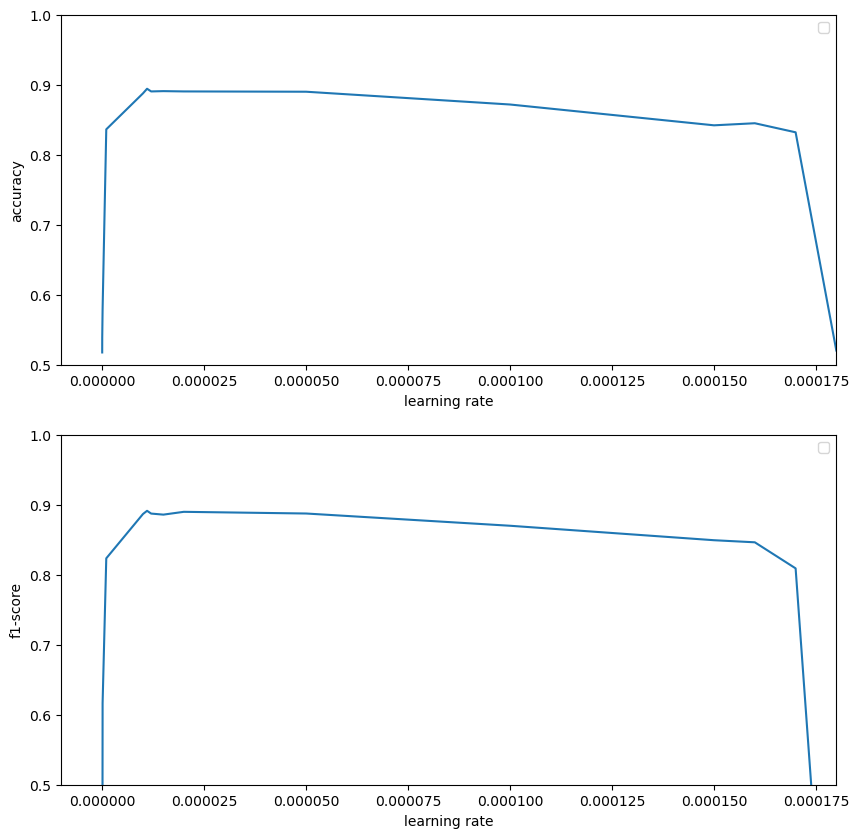

In [16]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(211, xlim=(-0.00001, 0.00018), ylim=(0.5, 1))
ax2 = fig.add_subplot(212, xlim=(-0.00001, 0.00018), ylim=(0.5, 1))

ax1.plot(df_lr.index, df_lr["accuracy"])
ax2.plot(df_lr.index, df_lr["f1-score"])

ax1.set_xlabel("learning rate")
ax2.set_xlabel("learning rate")

ax1.set_ylabel("accuracy")
ax2.set_ylabel("f1-score")

ax1.legend(loc='upper right') 
ax2.legend(loc='upper right') 

plt.show()

### Discussion
Models with different batch sizes and epochs had little effect on the results, while models with different learning rates (approximately 0.00001-0.0001) achieved 0.88-0.9 (accuracy, f1 score). All results of model with learning rates (~0.00001, 0.0001~) were predicted to be negative or positive.